In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math 
import seaborn as sns
import warnings
from scipy import stats
from sklearn.preprocessing import PowerTransformer

warnings.filterwarnings('ignore')


In [88]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
df_train.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [89]:
print(f"len(df_train) = {len(df_train)}")
print(f"len(df_test) = {len(df_test)}")

len(df_train) = 90615
len(df_test) = 60411


In [90]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [91]:
cols_float = df_train.select_dtypes(include=["float"]).columns.to_list()
cols_int = df_train.select_dtypes(include=["int64"]).columns.to_list()
cols_str = df_train.select_dtypes(include=["object"]).columns.to_list()
print("Float columns")
print(cols_float)
print("Int columns")
print(cols_int)
print("Categorical columns")
print(cols_str)

Float columns
['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
Int columns
['id', 'Rings']
Categorical columns
['Sex']


In [92]:
df_train.describe()

,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [93]:
def get_null_stats(df):
    null_count = df.isnull().sum()
    col_null_counts = {col: null_cnt for col, null_cnt in null_count.iteritems() if null_cnt > 0}
    if len(col_null_counts) == 0:
        print(f"There are no columns with null values")
    else:
        print(col_null_counts)

print("For train data")
get_null_stats(df_train)
print("For test data")
get_null_stats(df_test)


For train data
There are no columns with null values
For test data
There are no columns with null values


In [9]:
df_train['Sex'].value_counts()

I    33093
M    31027
F    26495
Name: Sex, dtype: int64

In [94]:
# # plot the distribution of numerical features and look for any outliers. Also check if train and test data have roughly the same distribution
# # for numerical features

# n_rows = len(cols_float)
# n_cols = 2

# fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,35), dpi=100)
# plt.subplots_adjust(hspace=0.3)
# for row in range(n_rows):
#     col = 0
#     col_name = cols_float[row]
#     sns.histplot(x=df[col_name], label="Train", kde=True, fill=True, color="orange", ax=axes[row, col])
#     sns.histplot(x=df_test[col_name], label="Test", kde=True, fill=True, color="teal", ax=axes[row, col])        
#     axes[row, 0].legend()
#     axes[row, 0].set_ylabel("count")
#     axes[row, 0].set_xlabel(col_name)
#     col = 1
#     sns.boxplot(x=df[col_name], orient='v', color='skyblue', ax=axes[row, col])
#     axes[row, 1].set_ylabel("")
#     axes[row, 1].set_xlabel(col_name)
#     axes[row, 1].set_title(f'Boxplot of train {col_name}', fontsize=12)
        
# plt.show()        

In [ ]:
# For numerical features having outliers, find the row count with outliers. Use IQR method to find outliers

def process_outliers_iqr(df, col_name, remove_outliers=True):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1    
    min_val = Q1 - 1.5 * IQR
    max_val = Q3 + 1.5 * IQR    
    outlier_count = df[(df[col_name] < min_val) | (df[col_name] > max_val)].shape[0]
    if remove_outliers:
        df = df[(df[col_name] >= min_val) & (df[col_name] <= max_val)]
    # Create a DataFrame for the results
    result = pd.DataFrame({
        'col_name': [col_name],
        'Q1': [Q1],
        'Q3': [Q3],
        'IQR': [IQR],
        'min_val': [min_val],
        'max_val': [max_val],
        'outlier_count': [outlier_count]
    })    
    return df, result

# Create an empty DataFrame to store the results
df_float_outliers = pd.DataFrame(columns=['col_name', 'Q1', 'Q3', 'IQR', 'min_val', 'max_val', 'outlier_count'])
for col_name in cols_float:
    df_train, df_col_ouliers = process_outliers_iqr(df_train, col_name)
    df_float_outliers = df_float_outliers.append(df_col_ouliers)
df_float_outliers = df_float_outliers.reset_index(drop=True)
df_float_outliers

In [95]:
def power_transform(df, col_name, skew_threshold=0.5):    
    transformed = False
    skew = df[col_name].skew()
    print(f"{col_name} has skewness of {skew}")
    power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)    
    if abs(skew) > skew_threshold:
        transformed = True
        print("Will apply power transform.")
        col_transformed = power_transformer.fit_transform(df[[col_name]])
        df.loc[:, col_name] = col_transformed
    return df, transformed

In [ ]:
def qq_plot(df, col_name, ax, title):
    probplot = stats.probplot(df[col_name], dist="norm")    
    # Plotting the quantiles
    ax.plot(probplot[0][0], probplot[0][1], 'o', label=col_name)
    # Plotting the reference line (45-degree line)
    ax.plot(probplot[0][0], probplot[1][1] + probplot[1][0] * probplot[0][0], '-', color='red', label='45-degree line')
    # Labeling
    ax.set_title(title)
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')
    ax.legend()

Length has skewness of -0.7320151933171148
Will apply power transform.
Diameter has skewness of -0.6952359660461651
Will apply power transform.
Height has skewness of 0.3099750611661875
Whole weight has skewness of 0.42931626303752013
Whole weight.1 has skewness of 0.5919732945442424
Will apply power transform.
Whole weight.2 has skewness of 0.4767333386805191
Shell weight has skewness of 0.4790924923513665


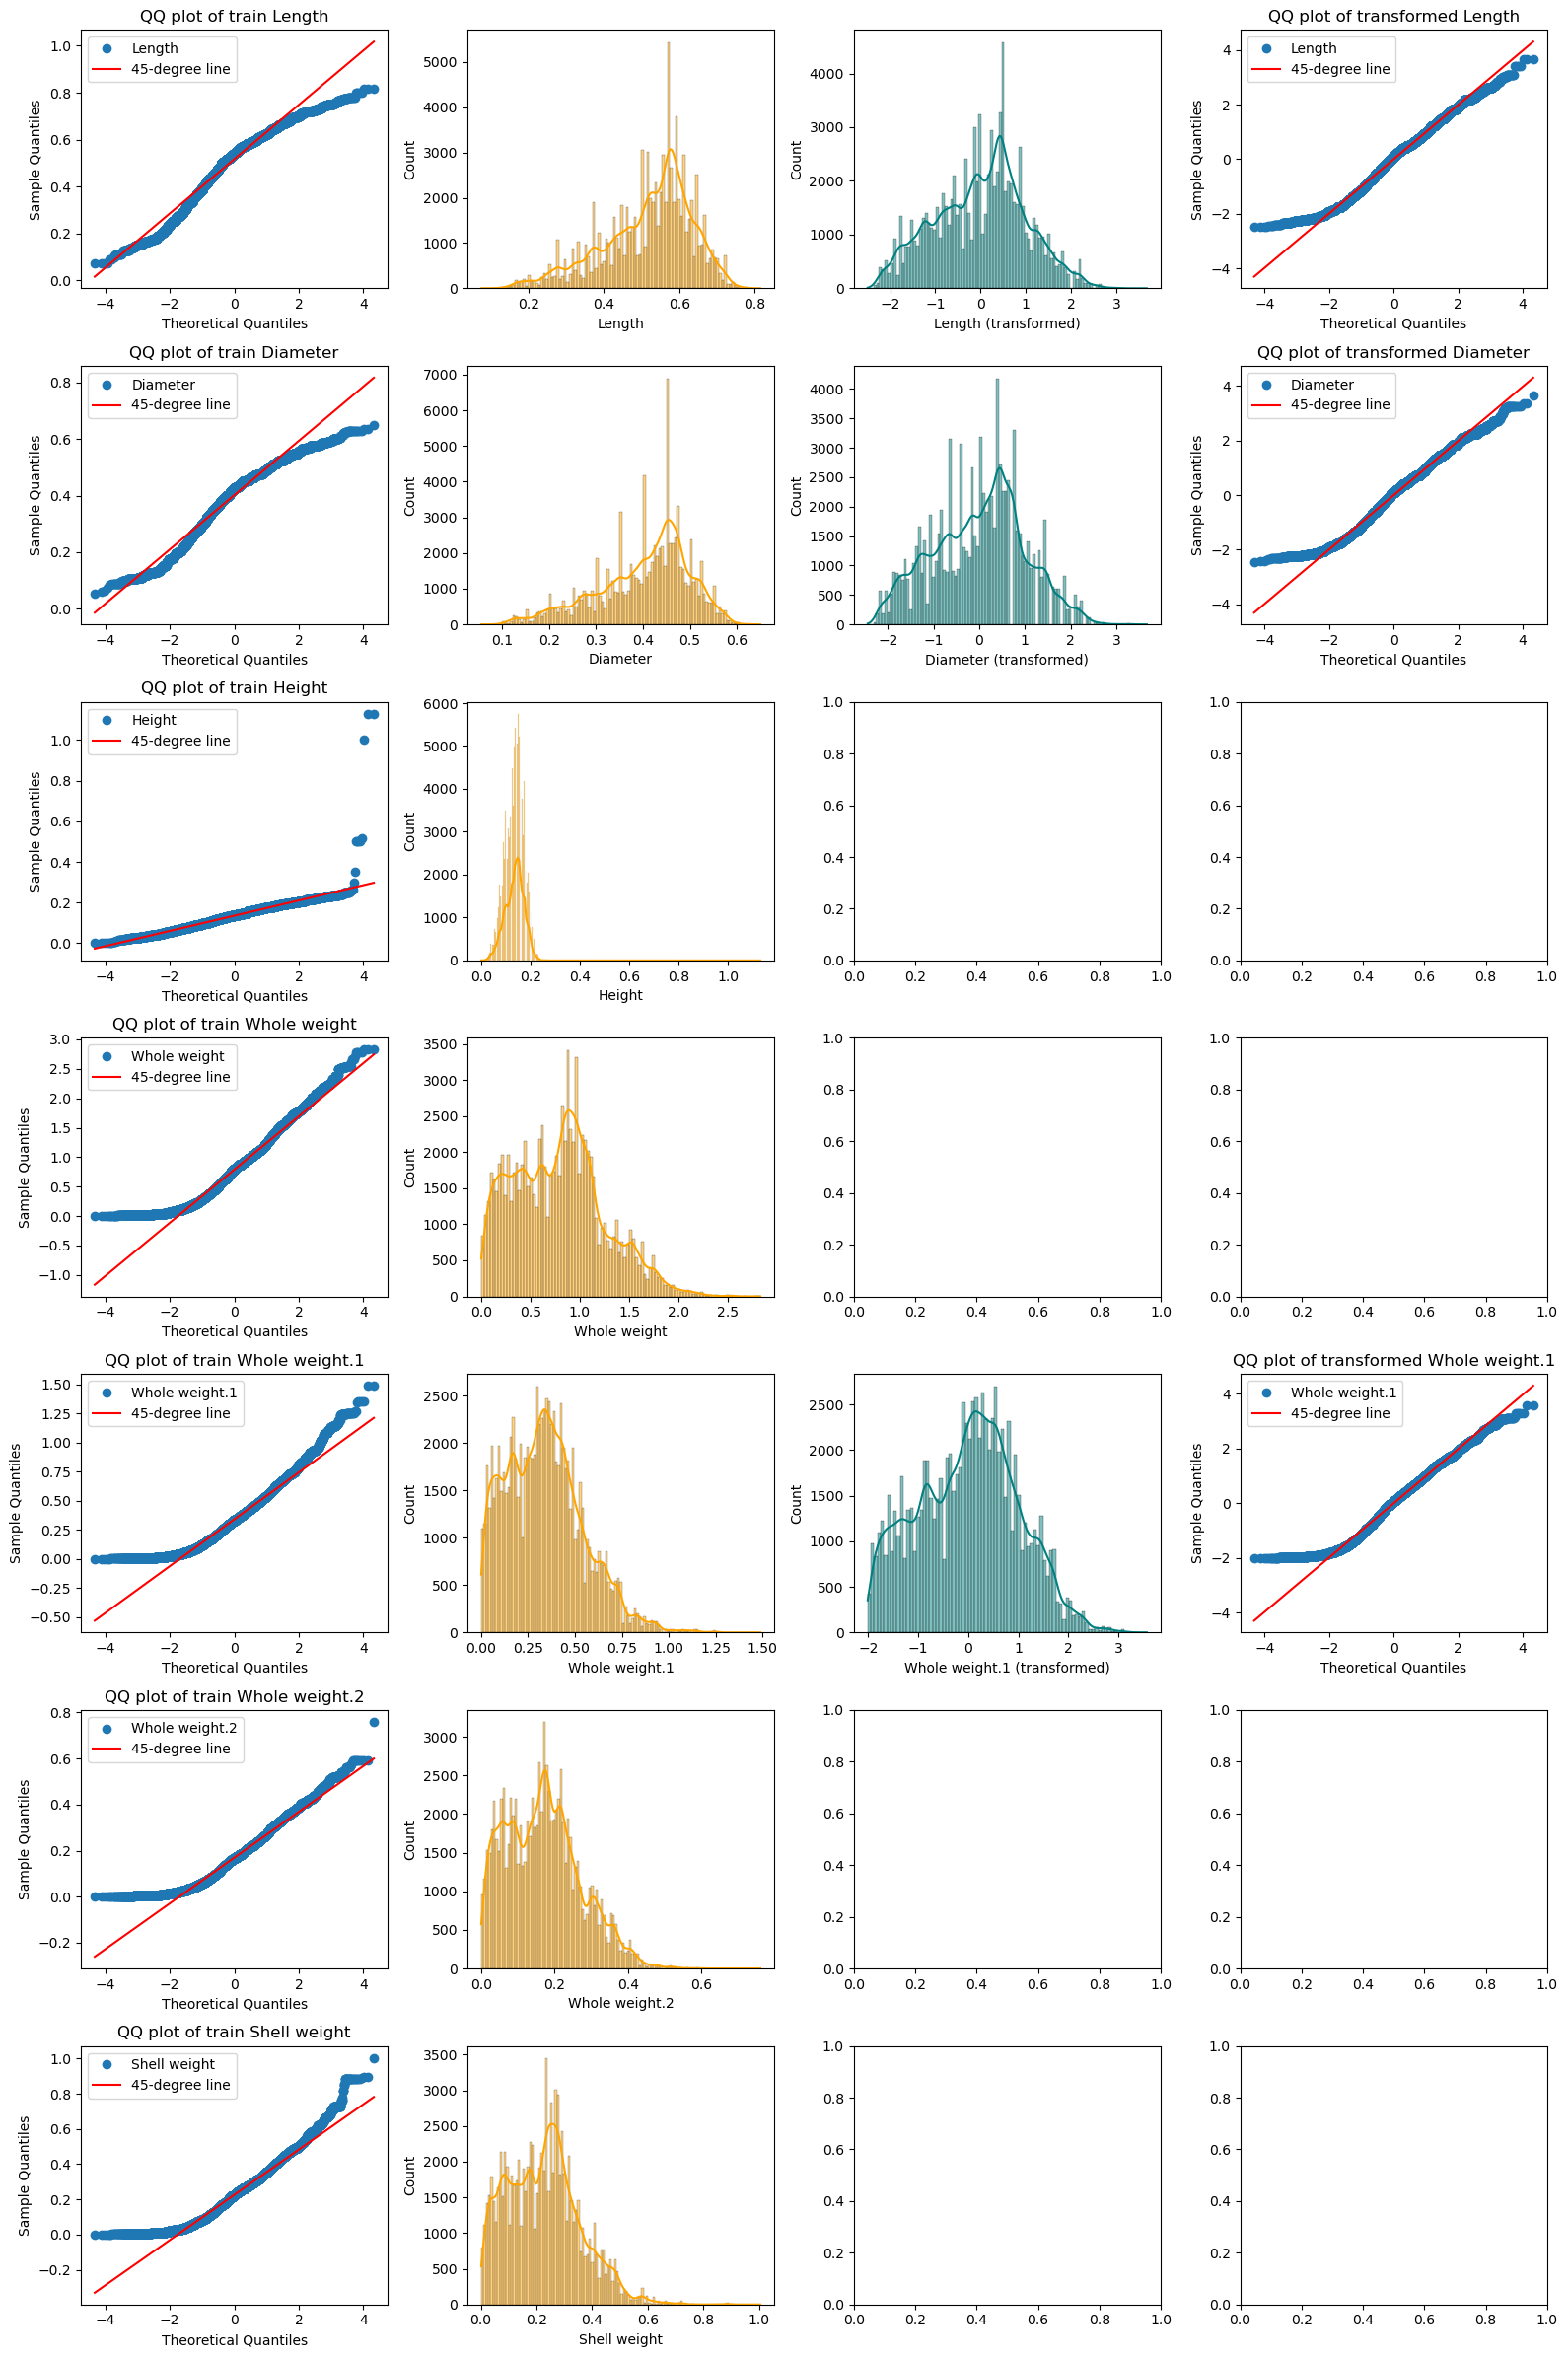

In [96]:
n_rows = len(cols_float)
n_cols = 4
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16,24), dpi=100)
plt.subplots_adjust(hspace=0.3)

for col_index, col_name in enumerate(cols_float):    
    ax = axes[col_index, 0]
    title = 'QQ plot of train ' + col_name
    qq_plot(df, col_name, ax, title)    
    ax = axes[col_index, 1]
    sns.histplot(x=df[col_name], label="Train", kde=True, fill=True, color="orange", ax=ax)    
    ax.set_xlabel(col_name)
    df, transformed = power_transform(df, col_name)        
    if transformed:
        ax = axes[col_index, 2]
        sns.histplot(x=df[col_name], label="Transformed Train", kde=True, fill=True, color="teal", ax=ax)
        ax.set_xlabel(col_name + ' (transformed)')
        title = 'QQ plot of transformed ' + col_name
        ax = axes[col_index, 3]
        qq_plot(df_train, col_name, ax, title)    
    
plt.tight_layout()
plt.show()

,col_name,Q1,Q3,IQR,min_val,max_val,outlier_count
0,Length,0.4450,0.6000,0.1550,0.21250,0.83250,1460
1,Diameter,0.3450,0.4700,0.1250,0.15750,0.65750,1580
2,Height,0.1100,0.1600,0.0500,0.03500,0.23500,348
3,Whole weight,0.4190,1.0675,0.6485,-0.55375,2.04025,574
4,Whole weight.1,0.1775,0.4630,0.2855,-0.25075,0.89125,967
5,Whole weight.2,0.0865,0.2325,0.1460,-0.13250,0.45150,440
6,Shell weight,0.1200,0.3050,0.1850,-0.15750,0.58250,671


In [13]:
df_train_numeric = df_train[cols_float + cols_int].drop(columns=["id"])
corr = df_train_numeric.corr()
target_correlation = corr["Rings"].sort_values(ascending=False)
print(target_correlation)

Rings             1.000000
Shell weight      0.694766
Height            0.665772
Diameter          0.636832
Length            0.623786
Whole weight      0.617274
Whole weight.2    0.588954
Whole weight.1    0.515067
Name: Rings, dtype: float64


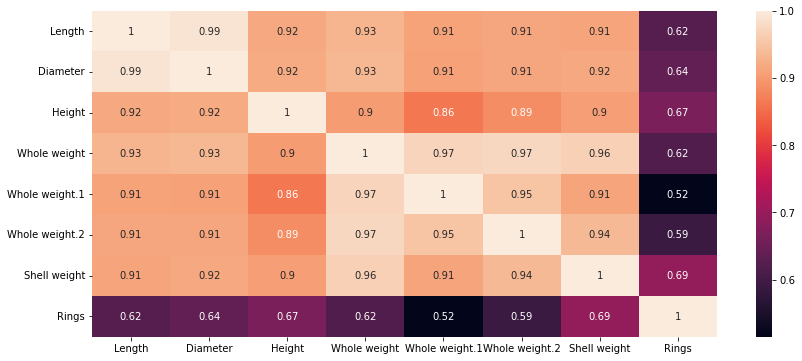

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))
ax = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, ax = ax)

In [16]:
train_height_skew = df_train["Diameter"].skew()
train_height_skew

-0.6952359660461651